# Quantifying Uncertainties with Flows

In the last tutorial, we used Invertible Neural Networks (INNs) to generate LHC data. This week, we will use them to study different types of uncertainties.

First, we will take the generative model and ask the question, how large the uncertainty arising from the network training and the limited training statistics is. This question can be answered using Bayesian Invertible Neural Networks (BINNs).

Next, we will look at a different type of uncertainties: The parton level data that we generated in the last tutorial is not what we would observe in an experiment. Instead we have to deal with lots of additional effects, like smearing from the detector. A common task is __unfolding__ these effects and, given one detector level event, ask what the corresponding parton level event was. There is no unique answer to that question, instead we will get a probability distribution over the possible parton level events.

Interesting papers:
- Invertible Networks or Partons to Detector and Back Again
    - Bellagente et al
    - https://arxiv.org/abs/2006.06685
- Generative Networks for Precision Enthusiasts
    - Butter et al
    - https://arxiv.org/abs/2110.13632
- Understanding Event-Generation Networks via Uncertainties
    - Bellagente et al
    - https://arxiv.org/abs/2104.04543

Outline:
- Imports and plotting set-up
- Loading the data
- Building and optimising the BINN
- Study the results
- Simple example for unfolding
- Study the results

You need install the FrEIA package to use the INN modules, you can install it from the terminal with:

The documentation can be found here:

https://github.com/VLL-HD/FrEIA

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
import math

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

## Loading the data

We can load the data from here:

In [2]:
dy_trn_data = np.load('tutorial-11-data/dy_trn_data.npy')
dy_val_data = np.load('tutorial-11-data/dy_val_data.npy')
dy_tst_data = np.load('tutorial-11-data/dy_tst_data.npy')

In [3]:
dy_trn_data.shape, dy_val_data.shape, dy_tst_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process. Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

To train the network, we will use the same parameterization and preprocessing as in the last tutorial.

In [4]:
def remove_dof(data_full):
    pt = np.sqrt(data_full[:,1]**2 + data_full[:,2]**2)
    eta1 = np.arctanh(data_full[:,3] / np.sqrt(data_full[:,1]**2 + data_full[:,2]**2 + data_full[:,3]**2))
    eta2 = np.arctanh(data_full[:,7] / np.sqrt(data_full[:,5]**2 + data_full[:,6]**2 + data_full[:,7]**2))
    return np.stack((pt, eta1, eta2), axis=1)
    
def add_dof(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.random.uniform(0, 2*np.pi, data_red.shape[:-1])
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

In [5]:
def get_obs(event):
    jet1_4m = event[...,0:4]
    jet2_4m = event[...,4:]
    evnt_4m = np.sum((jet1_4m,jet2_4m), axis=0)
    
    evnt_im = np.sqrt(np.sum((evnt_4m[...,0]**2, -evnt_4m[...,1]**2, -evnt_4m[...,2]**2, -evnt_4m[...,3]**2),
                              axis=0))
    
    evnt_pt = np.sqrt(evnt_4m[...,1]**2 + evnt_4m[...,2]**2)
    jet1_pt = np.sqrt(jet1_4m[...,1]**2 + jet1_4m[...,2]**2)
    jet2_pt = np.sqrt(jet2_4m[...,1]**2 + jet2_4m[...,2]**2)
    
    return evnt_im, evnt_pt, jet1_pt, jet2_pt

In [6]:
dy_trn_data_nr = remove_dof(dy_trn_data)
dy_val_data_nr = remove_dof(dy_val_data)
dy_tst_data_nr = remove_dof(dy_tst_data)

In [7]:
dy_trn_data_nr.shape, dy_val_data_nr.shape, dy_tst_data_nr.shape

((1384081, 3), (296588, 3), (296588, 3))

In [8]:
trn_mean_nr = np.mean(dy_trn_data_nr, axis=0)
trn_std_nr = np.std(dy_trn_data_nr, axis=0)
dy_trn_data_nr_p = torch.Tensor((dy_trn_data_nr - trn_mean_nr) / trn_std_nr)
dy_val_data_nr_p = torch.Tensor((dy_val_data_nr - trn_mean_nr) / trn_std_nr)
dy_tst_data_nr_p = torch.Tensor((dy_tst_data_nr - trn_mean_nr) / trn_std_nr)

In [9]:
trn_dataset_nr = TensorDataset(dy_trn_data_nr_p)
val_dataset_nr = TensorDataset(dy_val_data_nr_p)
tst_dataset_nr = TensorDataset(dy_tst_data_nr_p)
trn_dataloader_nr = DataLoader(trn_dataset_nr, batch_size=2500, shuffle=True)
val_dataloader_nr = DataLoader(val_dataset_nr, batch_size=2500, shuffle=True)
tst_dataloader_nr = DataLoader(tst_dataset_nr, batch_size=2500, shuffle=True)

## Building and optimizing the BINN

To turn the standard INN into a Bayesian INN, we need to replace the trainable parameters with means and standard deviations of Gaussian distributions. Since all the trainable parameters are found in the fully connected sub-networks of the coupling blocks, we have to replace the linear layers in these sub-networks. We can use the following class for that:

In [10]:
class VBLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False, std_init=-9):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def reset_random(self):
        self.random = None

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-11, 11)
        kl = 0.5 * (self.prior_prec * (self.mu_w.pow(2) + logsig2_w.exp())
                    - logsig2_w - 1 - np.log(self.prior_prec)).sum()
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map:
                return nn.functional.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(-11, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias) + 1e-8

    def __repr__(self):
        return f"{self.__class__.__name__} ({self.n_in}) -> ({self.n_out})"

The usual training setup:

In [11]:
def train_epoch(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (x, ) in enumerate(dataloader):
        # pass data through network
        z, log_jac_det = model(x)
        
        # compute loss
        loss = binn_loss(z, ndim_bay, log_jac_det)

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def val_pass(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x in dataloader:
            z, log_jac_det = model(x)
            vl += binn_loss(z, ndim_bay, log_jac_det).item()

    vl /= num_batches
    print(f"avg val loss per batch: {vl:>8f}")
    
    return vl

def trn_pass(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x in dataloader:
            z, log_jac_det = model(x)
            tl += binn_loss(z, ndim_bay, log_jac_det).item()

    tl /= num_batches
    print(f"avg trn loss per batch: {tl:>8f}")
    
    return tl

To build the BINN, we replace all Linear layers with VBLinear layers and add the KL divergence between the learned distribution and the prior distribution of the trainable parameters.

In [12]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 10

# re-initialise the model and the optimizer
bayesian_layers = []
def subnet_fc(dims_in, dims_out):
    l1 = VBLinear(dims_in, 32)
    l2 = VBLinear(32, 32)
    l3 = VBLinear(32, dims_out)
    bayesian_layers.extend([l1, l2, l3])
    return nn.Sequential(l1, nn.ReLU(), l2, nn.ReLU(), l3)

ndim_bay = 3
inn_bay = Ff.SequenceINN(ndim_bay)
for k in range(8):
    inn_bay.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
learning_rate = 0.001
optimizer_bay = torch.optim.Adam(inn_bay.parameters(), lr=learning_rate)
separator()
print("model architecture")
separator()
print(inn_bay)

def binn_loss( z, ndim, log_jac_det ):
    nf_loss = 0.5*torch.sum(z**2, 1) - log_jac_det
    kl_loss = sum(layer.KL() for layer in bayesian_layers) / len(dy_trn_data_nr)
    return (nf_loss.mean() + kl_loss) / ndim

# track train and val losses
trn_losses_bay = []
val_losses_bay = []

inn_bay.train()

for t in range(epochs):
    separator()
    print(f"Epoch {t+1}")
    separator()
    train_epoch(trn_dataloader_nr, inn_bay, optimizer_bay)
    separator()
    trn_loss = trn_pass(trn_dataloader_nr, inn_bay)
    trn_losses_bay.append(trn_loss)
    separator()
    val_loss = val_pass(val_dataloader_nr, inn_bay)
    val_losses_bay.append(val_loss)
    separator()
    print("|")
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
SequenceINN(
  (module_list): ModuleList(
    (0-7): 8 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): VBLinear (2) -> (32)
        (1): ReLU()
        (2): VBLinear (32) -> (32)
        (3): ReLU()
        (4): VBLinear (32) -> (2)
      )
    )
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.555709  [    0/1384081]
current batch loss: 0.144986  [250000/1384081]
current batch loss: 0.103390  [500000/1384081]
current batch loss: 0.053508  [750000/1384081]
current batch loss: 0.051355  [1000000/1384081]
current batch loss: -0.019378  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.025338
-----------------------------------------------
avg val loss per batch: -0.027321
-------------------

## Study the results

First let's plot the training and validation losses to see how they look.

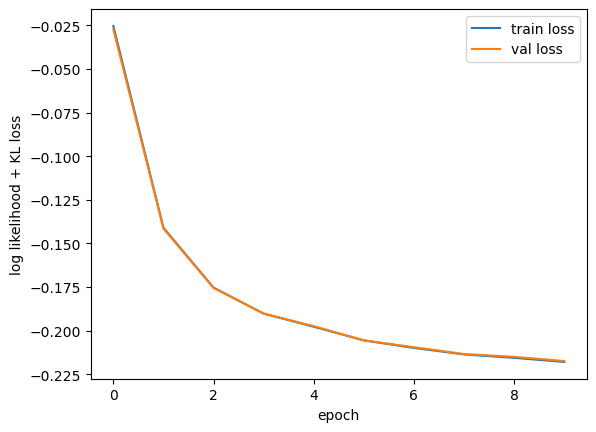

In [13]:
fig, axs = plt.subplots()

axs.plot(trn_losses_bay, label="train loss")
axs.plot(val_losses_bay, label="val loss")

axs.set_xlabel("epoch")
axs.set_ylabel("log likelihood + KL loss")
axs.legend()
plt.show()

Next, we need to generate some events. To extract the uncertainties learned by the BINN, we will repeat that for multiple samples from the distribution over the trainable weights. Then we can make histograms of observables for each of these samples and compute means and standard deviations for every histogram bin. This will give us histograms with error bars. Note that these error bars will not only contain the error learned by the BINN, but also the Poisson error from binning the data.

In [14]:
inn_bay.eval()
x_gen_bay = []
for i in range(20):
    [layer.reset_random() for layer in bayesian_layers]
    z_gen_bay = torch.randn((10000, ndim_bay))
    x_gen_bay.append(inn_bay(z_gen_bay, rev=True)[0])
x_gen_bay = torch.stack(x_gen_bay, axis=0)

x_gen_bay = x_gen_bay.detach().numpy() * trn_std_nr + trn_mean_nr
x_gen_bay = add_dof(x_gen_bay)

In [15]:
x_gen_bay.shape

(20, 10000, 8)

In [16]:
def bayesian_histogram(data, bins):
    histograms = np.stack([np.histogram(d, bins=bins, density=True)[0] for d in data], axis=0)
    return np.mean(histograms, axis=0), np.std(histograms, axis=0)

Again, we will look at histograms for different observables:

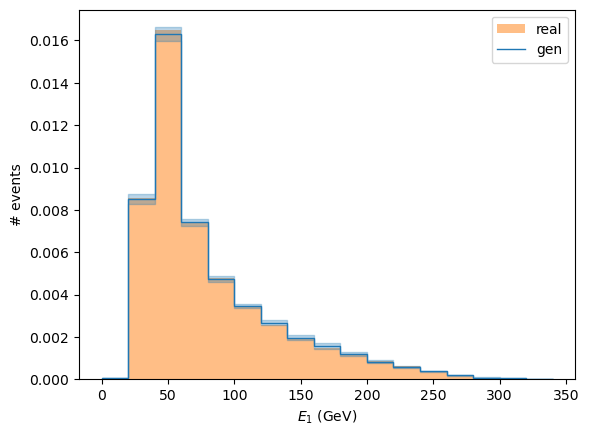

In [17]:
fig, axs = plt.subplots()

bins = np.arange(0, 350, step=20)
color_gen, color_real = "C0", "C1"
gen_means, gen_stds = bayesian_histogram(x_gen_bay[...,0], bins)
axs.hist(dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real', color=color_real)
dup_last = lambda a: np.append(a, a[-1])
axs.fill_between(bins, dup_last(gen_means - gen_stds), dup_last(gen_means + gen_stds), alpha=0.3, step="post",
                 color=color_gen)
axs.stairs(gen_means, bins, label="gen", color=color_gen)

axs.set_xlabel("$E_{1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

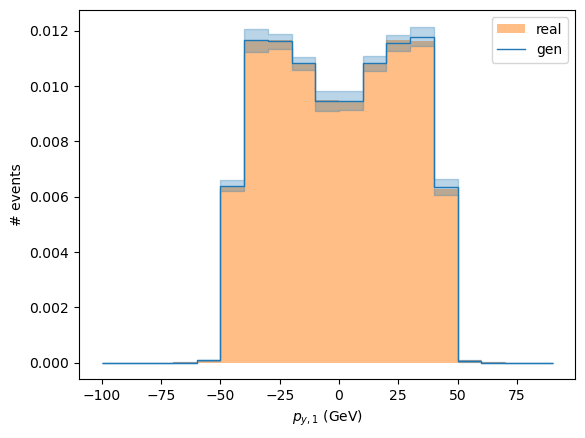

In [18]:
fig, axs = plt.subplots()

bins = np.arange(-100, +100, step=10)
color_gen, color_real = "C0", "C1"
gen_means, gen_stds = bayesian_histogram(x_gen_bay[...,6], bins)
axs.hist(dy_trn_data[:,6], alpha=0.5, density=True, bins=bins, label='real', color=color_real)
dup_last = lambda a: np.append(a, a[-1])
axs.fill_between(bins, dup_last(gen_means - gen_stds), dup_last(gen_means + gen_stds), alpha=0.3, step="post",
                 color=color_gen)
axs.stairs(gen_means, bins, label="gen", color=color_gen)

axs.set_xlabel("$p_{y,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

In [19]:
trn_evnt_ims, trn_evnt_pts, trn_jet1_pts, trn_jet2_pts = get_obs(dy_trn_data)
x_gen_evnt_bay_ims, x_gen_evnt_bay_pts, x_gen_jet1_bay_pts, x_gen_jet2_bay_pts = get_obs(x_gen_bay)

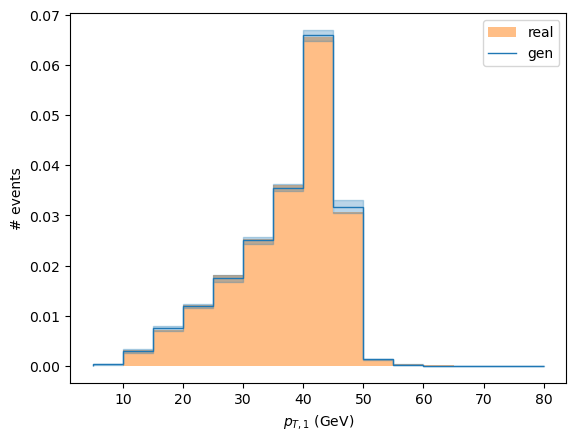

In [20]:
fig, axs = plt.subplots()

bins = np.arange(5, 85, step=5)
color_gen, color_real = "C0", "C1"
gen_means, gen_stds = bayesian_histogram(x_gen_jet1_bay_pts, bins)
axs.hist(trn_jet1_pts, alpha=0.5, density=True, bins=bins, label='real', color=color_real)
dup_last = lambda a: np.append(a, a[-1])
axs.fill_between(bins, dup_last(gen_means - gen_stds), dup_last(gen_means + gen_stds), alpha=0.3, step="post",
                 color=color_gen)
axs.stairs(gen_means, bins, label="gen", color=color_gen)

axs.set_xlabel("$p_{T,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

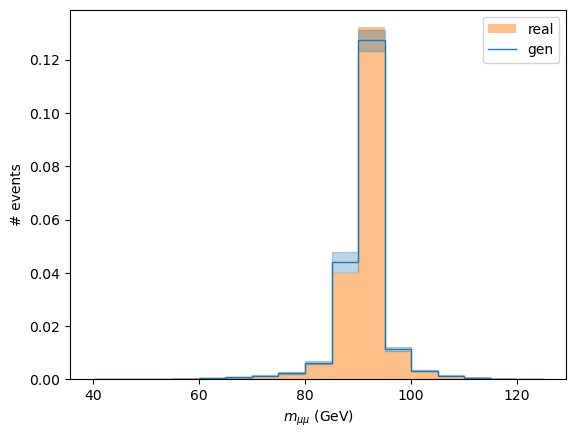

In [21]:
fig, axs = plt.subplots()

bins = np.arange(40, 130, step=5)
color_gen, color_real = "C0", "C1"
gen_means, gen_stds = bayesian_histogram(np.nan_to_num(x_gen_evnt_bay_ims), bins)
axs.hist(trn_evnt_ims, alpha=0.5, density=True, bins=bins, label='real', color=color_real)
dup_last = lambda a: np.append(a, a[-1])
axs.fill_between(bins, dup_last(gen_means - gen_stds), dup_last(gen_means + gen_stds), alpha=0.3, step="post",
                 color=color_gen)
axs.stairs(np.nan_to_num(gen_means), bins, label="gen", color=color_gen)

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

## Simple example for unfolding

So far we have studied Drell-Yan samples at the level of the hard process. Therefore we could assume conservation of momentum in the $x$ and $y$ direction. This is no longer the case as soon as we introduce detector effects. Also, there could be jets from Initial State Radiation that carry a part of the momentum. For a hadronic final state we would have to consider even more effects and sources of uncertainty, like Final State Radiation, parton shower, hadronization and jet reconstruction. As a toy example, we will take our Drell-Yan data, randomly split the first four-momentum in two parts, and then apply Gaussian noise and a bias to all three momenta:

 - sample $f \in [0,1]$ uniformly
 - define $q_1 = f p_1$, $q_2 = (1-f) p_1$, $q_3 = p_2$
 - apply Gaussian noise to $q_1$, $q_2$, $q_3$ component-wise by multiplying with samples from $\mathcal{N}(0.9, 0.05)$

In [22]:
def toy_detector_sim(data):
    split_frac = np.random.uniform(0,1,(len(data),1))
    q1 = split_frac * data[:,:4]
    q2 = (1.-split_frac) * data[:,:4]
    q3 = data[:,4:]
    q_all = np.concatenate((q1, q2, q3), axis=1)
    q_noise = q_all * np.random.normal(0.9, 0.05, q_all.shape)
    return q_noise

In [23]:
# Run toy detector simulation for training, validation and test data
det_trn_data = toy_detector_sim(dy_trn_data)
det_val_data = toy_detector_sim(dy_val_data)
det_tst_data = toy_detector_sim(dy_tst_data)

In [24]:
# Normalize detector-level data
det_trn_mean = np.mean(det_trn_data, axis=0)
det_trn_std = np.std(det_trn_data, axis=0)
det_trn_data_p = torch.Tensor((det_trn_data - det_trn_mean) / det_trn_std)
det_val_data_p = torch.Tensor((det_val_data - det_trn_mean) / det_trn_std)
det_tst_data_p = torch.Tensor((det_tst_data - det_trn_mean) / det_trn_std)

In [25]:
# Choose four-momentum representation of parton-level data with reduced DOF
def remove_dof_4mom(data_full):
    return data_full[:, [1,2,3,7]]
    
def add_dof_4mom(data_red):
    px1 = data_red[:,0]
    py1 = data_red[:,1]
    pz1 = data_red[:,2]
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = data_red[:,3]
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

In [26]:
# Remove redundant DOF from parton-level data
par_trn_data = remove_dof_4mom(dy_trn_data)
par_val_data = remove_dof_4mom(dy_val_data)
par_tst_data = remove_dof_4mom(dy_tst_data)

# Normalize parton-level data
par_trn_mean = np.mean(par_trn_data, axis=0)
par_trn_std = np.std(par_trn_data, axis=0)
par_trn_data_p = torch.Tensor( (par_trn_data - par_trn_mean) / par_trn_std )
par_val_data_p = torch.Tensor( (par_val_data - par_trn_mean) / par_trn_std )
par_tst_data_p = torch.Tensor( (par_tst_data - par_trn_mean) / par_trn_std )

In [27]:
# Create combined datasets and dataloaders with parton- and detector-level data
unf_trn_dataset = TensorDataset( par_trn_data_p, det_trn_data_p )
unf_val_dataset = TensorDataset( par_val_data_p, det_val_data_p )
unf_tst_dataset = TensorDataset( par_tst_data_p, det_tst_data_p )

unf_trn_dataloader = DataLoader( unf_trn_dataset, batch_size=2500, shuffle=True )
unf_val_dataloader = DataLoader( unf_val_dataset, batch_size=2500, shuffle=True )
unf_tst_dataloader = DataLoader( unf_tst_dataset, batch_size=2500, shuffle=True )

Now let's define a conditional INN that learns the probability distribution $p(\mathrm{parton} | \mathrm{detector} )$.

In [28]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    return l.mean() / ndim_unf

def train_epoch_unfolding(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (x, c) in enumerate(dataloader):
        # pass data through network
        z, log_jac_det = model(x, c=(c,))
        
        # compute loss
        loss = inn_loss(z, ndim_unf, log_jac_det)

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def val_pass_unfolding(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x, c in dataloader:
            z, log_jac_det = model(x, c=(c,))
            vl += inn_loss(z, ndim_unf, log_jac_det).item()

    vl /= num_batches
    print(f"avg val loss per batch: {vl:>8f}")
    
    return vl

def trn_pass_unfolding(dataloader, model):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x, c in dataloader:
            z, log_jac_det = model(x, c=(c,))
            tl += inn_loss(z, ndim_unf, log_jac_det).item()

    tl /= num_batches
    print(f"avg trn loss per batch: {tl:>8f}")
    
    return tl

In [29]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 10

# re-initialise the model and the optimizer
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential(
        nn.Linear(dims_in, 32), 
        nn.ReLU(),
        nn.Linear(32, 32), 
        nn.ReLU(),
        nn.Linear(32,  dims_out)
    )
ndim_unf = 4
inn_unf = Ff.SequenceINN(ndim_unf)
for k in range(8):
    inn_unf.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True, cond=0, cond_shape=(12,))
learning_rate = 0.001
optimizer_unf = torch.optim.Adam(inn_unf.parameters(), lr=learning_rate)
separator()
print("model architecture")
separator()
print(inn_unf)

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print(f"Epoch {t+1}")
    separator()
    train_epoch_unfolding(unf_trn_dataloader, inn_unf, optimizer_unf)
    separator()
    trn_loss = trn_pass_unfolding(unf_trn_dataloader, inn_unf)
    trn_losses.append(trn_loss)
    separator()
    val_loss = val_pass_unfolding(unf_val_dataloader, inn_unf)
    val_losses.append(val_loss)
    separator()
    print("|")
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
SequenceINN(
  (module_list): ModuleList(
    (0-7): 8 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=14, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=4, bias=True)
      )
    )
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.503063  [    0/1384081]
current batch loss: -0.841045  [250000/1384081]
current batch loss: -2.515268  [500000/1384081]
current batch loss: -2.781661  [750000/1384081]
current batch loss: -2.902942  [1000000/1384081]
current batch loss: -2.933173  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -2.951103
---------

## Study the results

First let's plot the training and validation losses to see how they look.

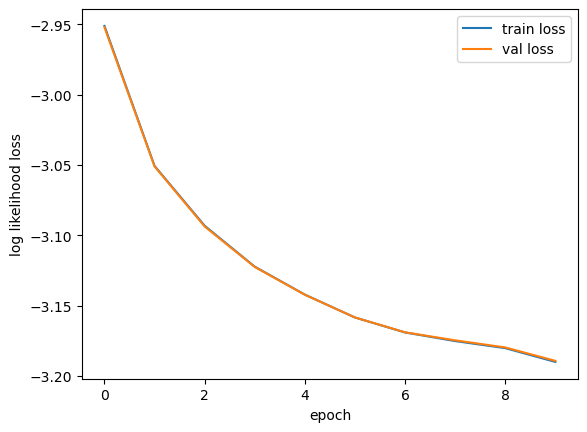

In [30]:
fig, axs = plt.subplots()

axs.plot(trn_losses, label="train loss")
axs.plot(val_losses, label="val loss")

axs.set_xlabel("epoch")
axs.set_ylabel("log likelihood loss")
axs.legend()
plt.show()

Let's send the whole test data set through the cINN and unfold each detector-level event once. We should recover the prior distribution, i.e. $p(\mathrm{parton})$. We can check that by plotting some kinematic distributions, like for the generative network.

In [31]:
z_gen_unf = torch.randn((len(det_tst_data_p), ndim_unf))
x_gen_unf, _ = inn_unf(z_gen_unf, c=(det_tst_data_p, ), rev=True)
x_gen_unf = x_gen_unf.detach().numpy() * par_trn_std + par_trn_mean
x_gen_unf = add_dof_4mom(x_gen_unf)

In [32]:
z_gen_unf = torch.randn((len(det_tst_data_p), ndim_unf))
x_gen_unf, _ = inn_unf(z_gen_unf, c=(det_tst_data_p, ), rev=True)
x_gen_unf = x_gen_unf.detach().numpy() * par_trn_std + par_trn_mean
x_gen_unf = add_dof_4mom(x_gen_unf)

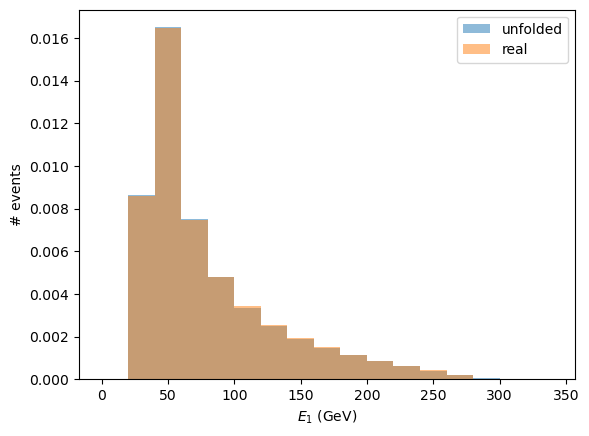

In [33]:
fig, axs = plt.subplots()

bins = np.arange(0, 350, step=20)
axs.hist(x_gen_unf[:,0], alpha=0.5, density=True, bins=bins, label='unfolded')
axs.hist(dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$E_{1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

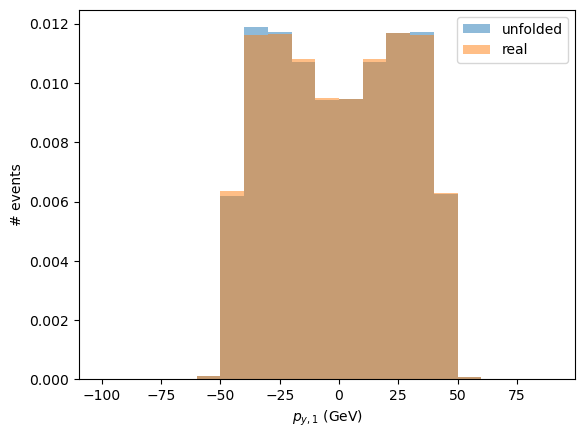

In [34]:
fig, axs = plt.subplots()

bins = np.arange(-100, +100, step=10)
axs.hist(x_gen_unf[:,6], alpha=0.5, density=True, bins=bins, label='unfolded')
axs.hist(dy_trn_data[:,6], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{y,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

In [35]:
x_gen_evnt_unf_ims, x_gen_evnt_unf_pts, x_gen_jet1_unf_pts, x_gen_jet2_unf_pts = get_obs(x_gen_unf)

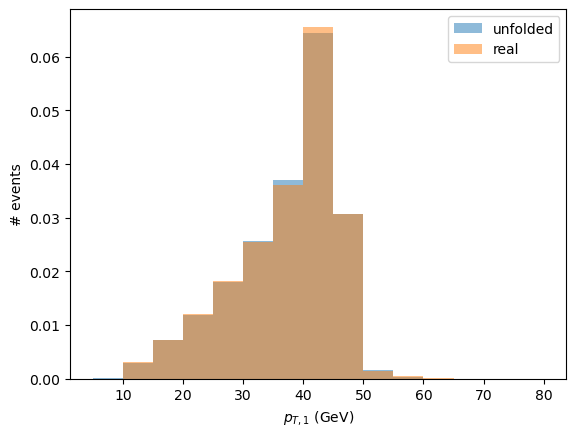

In [37]:
fig, axs = plt.subplots()

bins = np.arange(5, 85, step=5)
axs.hist(x_gen_jet1_unf_pts, alpha=0.5, density=True, bins=bins, label='unfolded')
axs.hist(trn_jet1_pts, alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{T,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

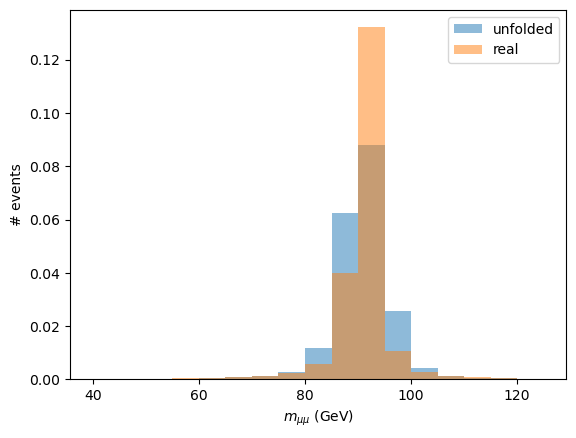

In [38]:
fig, axs = plt.subplots()

bins = np.arange(40, 130, step=5)
axs.hist(np.nan_to_num(x_gen_evnt_unf_ims), alpha=0.5, density=True, bins=bins, label='unfolded')
axs.hist(np.nan_to_num(trn_evnt_ims), alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

Most distributions were reproduced nicely. However, the performance for the mass peak decreased a bit.

While checking that the prior distribution is recovered is a useful sanity check, we are more interested in the distribution of parton-level events for individual measured detector-level events that we want to unfold. So let's take the first few events of the test dataset, unfold them multiple times and look at the distributions.

In [39]:
n_samples = 1000
n_events = 10

x_gen_unf_single = []

for i in range(n_events):
    z = torch.randn((n_samples, ndim_unf))
    c = det_tst_data_p[i].repeat(n_samples, 1)
    x, _ = inn_unf(z, c=(c, ), rev=True)
    x = x.detach().numpy() * par_trn_std + par_trn_mean
    x = add_dof_4mom(x)
    x_gen_unf_single.append(x)

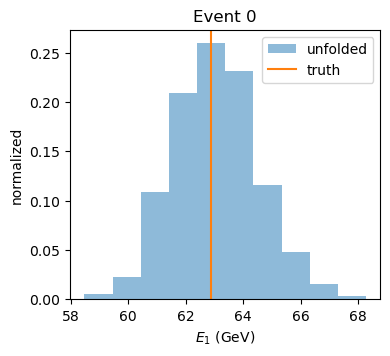

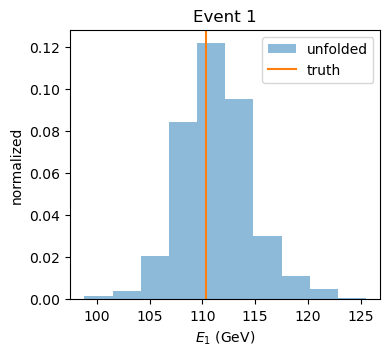

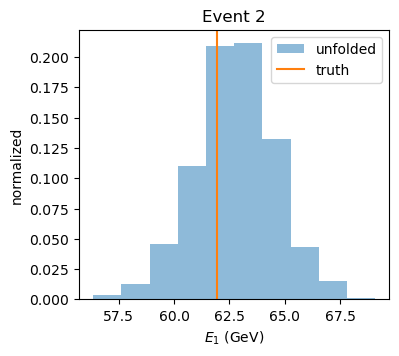

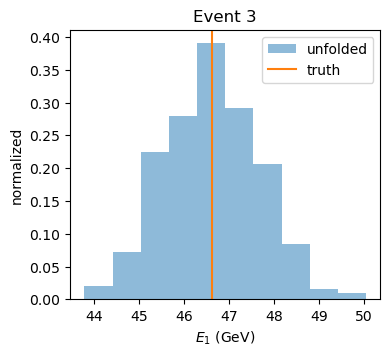

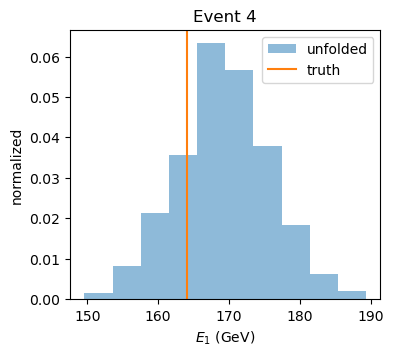

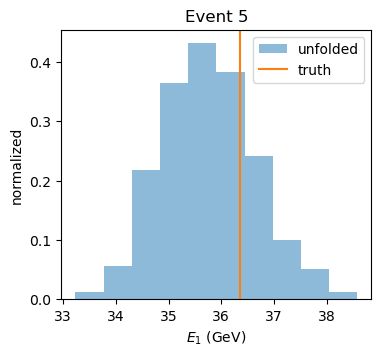

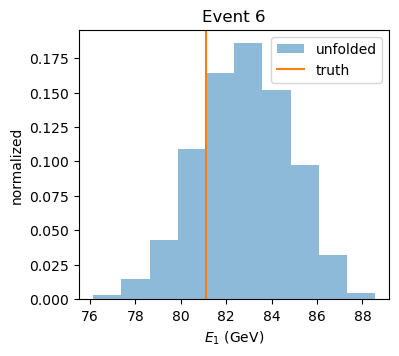

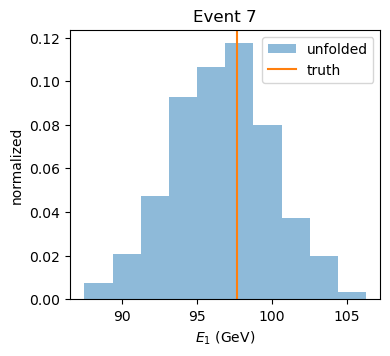

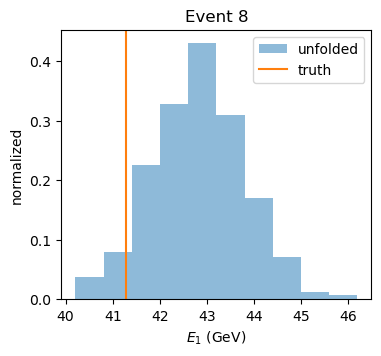

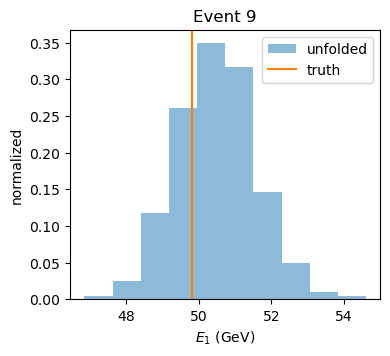

In [40]:
for i, x in enumerate(x_gen_unf_single):
    fig, axs = plt.subplots(figsize=(4,3.5))

    axs.hist(x[:,0], alpha=0.5, density=True, bins=10, label='unfolded')
    axs.axvline(dy_tst_data[i,0], label='truth', color="C1")

    axs.set_xlabel("$E_{1}$ (GeV)")
    axs.set_ylabel("normalized")
    axs.legend()
    axs.set_title(f"Event {i}")
    plt.show()